In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
from os import listdir
from typing import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import time


In [3]:
def pct_change(arr: Union[np.ndarray, pd.DataFrame]) -> Union[np.ndarray, pd.DataFrame]:
    return np.diff(arr, axis=0) / arr[:-1]

class TickerDataGenerator:
    """
    Class to Generate Train and Test Data from a list of tickers and a directory.
    ---------
    Requirements: csv files of price data stored within a single directory (data_dir param)
    ---------
    PARAMS
        1. tickers: a list of tickers used to create training data from
        2. data_path: directory where data is stored in csv's
    ---------
    """
    def __init__(self, tickers: Union[list,str], data_dir: str):
        if type(tickers) is str:
            tickers = [tickers]
        tickers = [t.replace(".csv", "") for t in tickers]
        self.path = data_dir
        self.tickers = tickers
        self.__check_files()
        self.scaler = MinMaxScaler(feature_range=(-1, 1))

    def __call__(self) -> pd.DataFrame:
        return self.generate_data()

    def generate_data(self) -> pd.DataFrame:
        #********** Helper functions **************
        def filter_by_date(df: pd.DataFrame) -> pd.DataFrame:
            return df[(df.date >= start) & (df.date <= end)].reset_index(drop=True)
                    #-----------------
        def rename_cols(ticker: str, df: pd.DataFrame) -> pd.DataFrame:
            old_cols = [col for col in df.columns if col != "date"]
            new_cols = [f"{ticker}_{col}" for col in old_cols]
            return df.rename(columns=dict(zip(old_cols, new_cols)))
                    #-----------------
        def as_pct_change(df: pd.DataFrame) -> pd.DataFrame:
            df.close = np.cumsum(df.close.pct_change)
            df.dropna(inplace=True)
            return df
        #******************************************
        df_list = []
        for ticker in self.tickers:
            df_list.append(self.timestamp_to_date(self.__load_data(ticker)))
        start = max([df.date.min() for df in df_list])
        end = min([df.date.max() for df in df_list])

        df_list = [filter_by_date(df) for df in df_list]
        df_list = [rename_cols(ticker, df) for ticker, df in list(zip(self.tickers, df_list))]

        return reduce(lambda x, y: pd.merge(x, y, on = 'date'), df_list)

    def __load_data(self, ticker: str) -> pd.DataFrame:
        assert f"{ticker}.csv" in listdir(self.path), f"{ticker} not in {self.path}"
        return pd.read_csv(f"{self.path}/{ticker}.csv")

    def __check_files(self):
        files = listdir(self.path)
        for ticker in self.tickers:
            assert f"{ticker}.csv" in files, f"{ticker}.csv not in {self.path}"
                
    def timestamp_to_date(self, df: pd.DataFrame, as_index: bool = False) -> pd.DataFrame:
        df.date = pd.to_datetime(df.date).apply(lambda d: d.date())
        if as_index:
            df.set_index('date', inplace=True)
        return df

    def __train_test_split(self, arr: np.ndarray, period: int, split_perc: float) -> Tuple[np.ndarray]:
        if type(arr) is pd.DataFrame:
            arr = arr.values

        data = []
        for idx in range(len(arr) - period):
            data.append(arr[idx: idx+period])
            
        data = np.array(data)
        test_size = int(data.shape[0] * split_perc)
        train_size = data.shape[0] - test_size

        X_train, X_test = data[:train_size,:-1,:], data[train_size:,:-1]
        y_train, y_test = data[:train_size,-1,:], data[train_size:,-1,:]

        return X_train, y_train, X_test, y_test

    def create_train_data(self, 
                          feature_cols: List[Text], 
                          label_col: str,
                          split_perc: float,
                          period: int,
                          as_pct_change: bool, 
                          as_cumsum: bool) -> Tuple[Union[np.ndarray, List]]:
        #********** Helper functions **************
                    #-----------------
        def column_handler():
            features, allowed_cols = {}, ['close', 'open' ,'high', 'low', 'date', 'volume']
            for f in feature_cols:
                assert f in allowed_cols, f"{f} not found. Must be in {allowed_cols}"
                features[f] = [x for x in df.columns if x.find(f) != -1]
            return features
                    #-----------------
        def split_by_ticker(df: pd.DataFrame) -> list:
            ticker_data = []
            for ticker in self.tickers:
                ticker_data.append(df[[x for x in df.columns if x.find(ticker) != -1]])
            return ticker_data
                    #-----------------
        #******************************************
        assert label_col in feature_cols, f"{label_col} must be included in {feature_cols}"
        assert 0.0 <= split_perc <= 1.0, "Split percentage must be between 0 and 1"

        feature_cols = [x.lower() for x in feature_cols]
        df = self.generate_data()
        feature_cols = column_handler()
        df = df[np.array(list(feature_cols.values())).flatten()] #filter out columns we don't want
        df = split_by_ticker(df) #splits data by ticker so we can generate training data for each

        label_feature_index = [x.split("_")[1] for x in df[0]].index(label_col) #get col index of our y value

        if as_pct_change:
            df = [pct_change(d) for d in df] #handles for each column
        if as_cumsum:
            df = [np.cumsum(d, axis=0) for d in df] #handles for each column

        #xtrain/ytrain can be one big array but ytest/xtest should be a list for each ticker so we can visualize later
        all_X_train, all_y_train, all_X_test, all_y_test = [],[],[],[]
        for data in df:
            X_train, y_train, X_test, y_test = self.__train_test_split(data, period, split_perc)
            all_X_train.append(X_train)
            all_y_train.append(y_train[:,label_feature_index]) #filter for only label column
            all_X_test.append(X_test)
            all_y_test.append(y_test[:,label_feature_index])

        return np.concatenate(all_X_train), np.concatenate(all_y_train), all_X_test, all_y_test
        



In [4]:
PATH = "gdrive/MyDrive/PriceData/PriceData"
TICKER_LIST = ["AAPL", "AMZN", "MMM", "ABT", "KR"]
FEATURES = ["close", "high"]
LABEL = "close"
SPLIT_PERC = 0.2
PERIOD = 20

data_gen = TickerDataGenerator(TICKER_LIST, PATH)

X_train, y_train, X_test, y_test = data_gen.create_train_data(feature_cols = FEATURES, 
                                                              label_col = LABEL,
                                                              split_perc=SPLIT_PERC,
                                                              period=PERIOD,
                                                              as_pct_change=True, 
                                                              as_cumsum=True)
X_train.shape, y_train.shape


((24195, 19, 2), (24195,))

In [5]:
def fit_scaler(scaler, X_train, y_train, X_test, y_test):
    #we want the scaler to handle all sorts of price action, high volatility to low...so fit all together
    data_to_scale = np.concatenate([X_train.flatten(), 
                                    y_train.flatten(), 
                                    np.array(X_test).flatten(), 
                                    np.array(y_test).flatten()]).reshape(-1,1)
    scaler.fit(data_to_scale)


scaler = MinMaxScaler(feature_range=(-1, 1))
fit_scaler(scaler, X_train, y_train, X_test, y_test)


In [6]:
X_train = np.array([scaler.transform(x) for x in X_train])
y_train = np.array([scaler.transform(y.reshape(-1,1)) for y in y_train])
X_test =  [np.array([scaler.transform(x) for x in ticker]) for ticker in X_test]
#dont need to scale y_test


In [7]:
X_train = torch.from_numpy(X_train).type(torch.Tensor)
X_test = [torch.from_numpy(x).type(torch.Tensor) for x in X_test]
y_train = torch.from_numpy(y_train).type(torch.Tensor).reshape(-1,1)


In [8]:
INPUT_DIM = X_train.size(-1)
NUM_LAYERS = 2
OUTPUT_DIM = y_train.size(-1)
NUM_EPOCHS = 50


In [9]:
class PricePredictionGRU(nn.Module):
    def __init__(self, input_dim, num_layers, output_dim):
        super(PricePredictionGRU, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_layers = num_layers

        self.GRU = nn.GRU(input_dim, 
                          32, 
                          num_layers, 
                          batch_first=True)
        self.dense1 = nn.Linear(32, 8)
        self.dense2 = nn.Linear(8, output_dim)

    def forward(self, X):
        hidden_0 = torch.zeros(self.num_layers, X.size(0), 32).requires_grad_()
        out, _ = self.GRU(X, hidden_0)
        out = self.dense2(self.dense1(out[:, -1, :]))
        return out

model = PricePredictionGRU(INPUT_DIM, NUM_LAYERS, OUTPUT_DIM)
criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)



In [11]:
def train_model():
    hist = np.zeros(NUM_EPOCHS)
    start_time = time.time()
    for e in range(NUM_EPOCHS):
        optimizer.zero_grad()
        yhat = model(X_train)
        loss = criterion(yhat, y_train)
        print(f"Epoch: {e} || MSE: {loss.item()}\n")
        hist[e] = loss.item()
        loss.backward()
        optimizer.step()

    print(f"Total Time Elapsed: {time.time()-start_time}")
    return hist

hist = train_model()



Epoch: 0 || MSE: 0.77659672498703

Epoch: 1 || MSE: 0.46460992097854614

Epoch: 2 || MSE: 0.2511882483959198

Epoch: 3 || MSE: 0.10545259714126587

Epoch: 4 || MSE: 0.16133572161197662

Epoch: 5 || MSE: 0.14791390299797058

Epoch: 6 || MSE: 0.07258925586938858

Epoch: 7 || MSE: 0.06299839913845062

Epoch: 8 || MSE: 0.07987287640571594

Epoch: 9 || MSE: 0.0686914473772049

Epoch: 10 || MSE: 0.03369472548365593

Epoch: 11 || MSE: 0.007539472077041864

Epoch: 12 || MSE: 0.015619602985680103

Epoch: 13 || MSE: 0.03301862254738808

Epoch: 14 || MSE: 0.023379357531666756

Epoch: 15 || MSE: 0.006659326609224081

Epoch: 16 || MSE: 0.007813953794538975

Epoch: 17 || MSE: 0.01931372657418251

Epoch: 18 || MSE: 0.023233016952872276

Epoch: 19 || MSE: 0.01592676341533661

Epoch: 20 || MSE: 0.005793704651296139

Epoch: 21 || MSE: 0.001821196754463017

Epoch: 22 || MSE: 0.005238874815404415

Epoch: 23 || MSE: 0.009508326649665833

Epoch: 24 || MSE: 0.008979779668152332

Epoch: 25 || MSE: 0.005067442

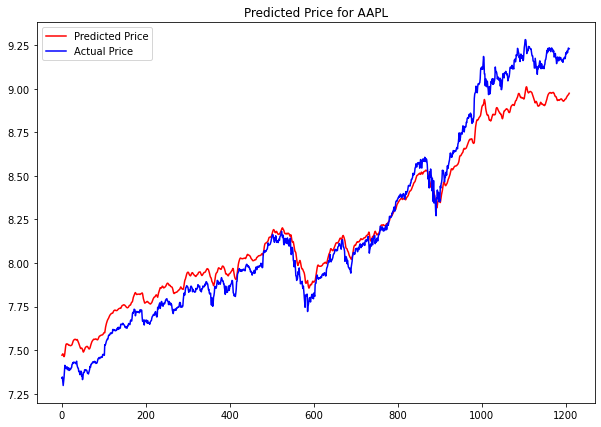

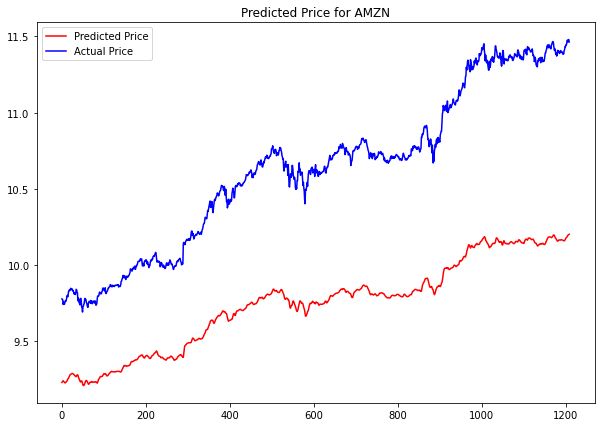

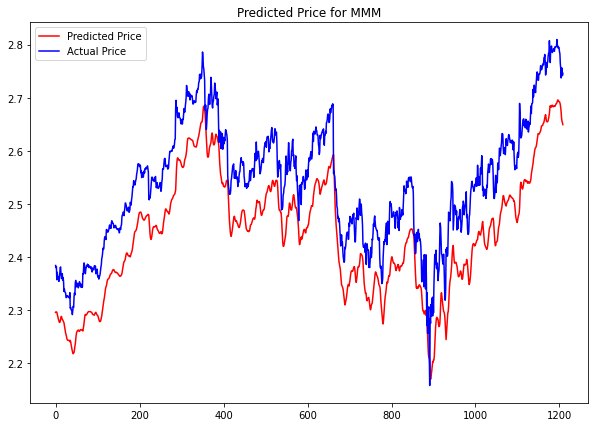

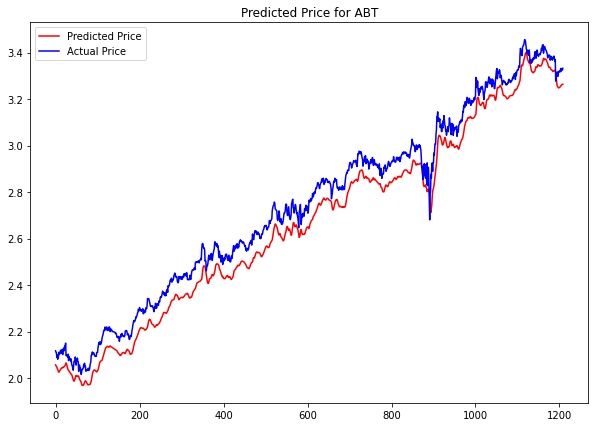

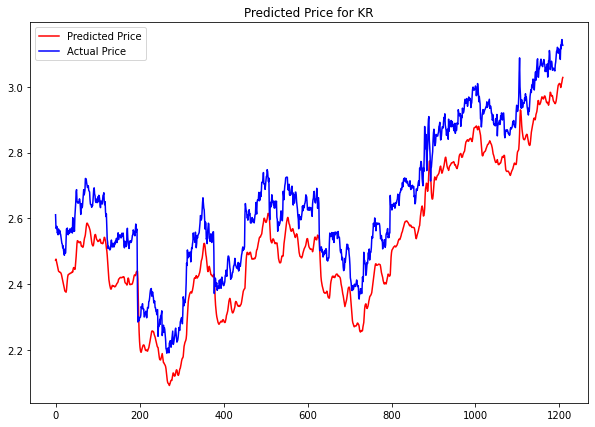

In [13]:
for idx in range(len(TICKER_LIST)):
    ticker = TICKER_LIST[idx]

    ticker_test = X_test[idx]

    ticker_yhat = model(ticker_test)
    ticker_yhat = scaler.inverse_transform(ticker_yhat.detach())
    ticker_y = y_test[idx]

    #Plot Predicted vs Acutal
    plt.figure(figsize=(10,7))
    plt.plot(ticker_yhat, c="red", label="Predicted Price")
    plt.plot(ticker_y, c="blue", label="Actual Price")
    plt.legend()
    plt.title(f"Predicted Price for {ticker}")
    plt.show()


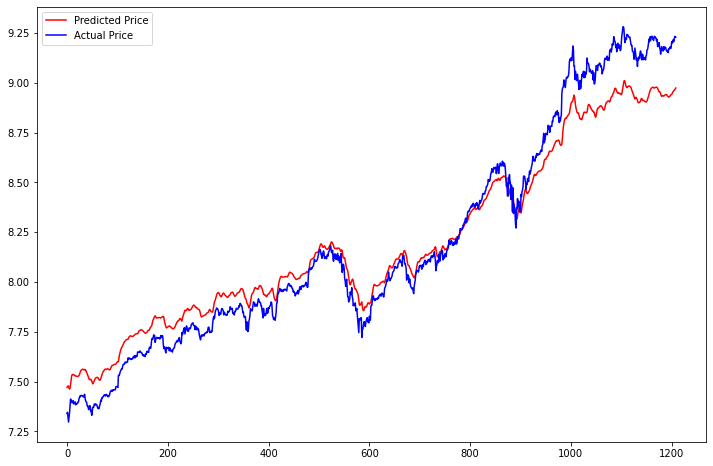

In [14]:
TICKER_IDX = 0

ticker_test = X_test[TICKER_IDX]
ticker_yhat = model(ticker_test)
ticker_yhat = scaler.inverse_transform(ticker_yhat.detach())
ticker_y = y_test[TICKER_IDX]

#Plot Predicted vs Acutal
plt.figure(figsize=(12,8))
plt.plot(ticker_yhat, c="red", label="Predicted Price")
plt.plot(ticker_y, c="blue", label="Actual Price")
plt.legend()
plt.show()